# Spotify Tracks — Exploratory Data Analysis (EDA)
**Author:** Divya Chougule  
**Last updated:** Feb 2025

This notebook explores the *Spotify Tracks Dataset* (Kaggle) and focuses on:
- data quality checks & cleaning
- exploratory visual analysis (distributions, relationships, segments)
- feature engineering and “story” insights
- light unsupervised exploration (PCA + clustering) to uncover patterns

> **How to run:** Download the Kaggle dataset CSV and place it in the same folder as this notebook as `spotify_tracks.csv` (or update the path in the loading cell).


In [1]:
# Core libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional (safe-to-skip) extras
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Make charts readable
plt.rcParams["figure.figsize"] = (10, 5)

## 1) Load data
The Kaggle *Spotify Tracks Dataset* is commonly distributed with columns like:

- `track_name`, `artists`, `album_name` (names/metadata)
- `popularity` (0–100)
- `duration_ms`
- audio features: `danceability`, `energy`, `loudness`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence`, `tempo`
- categorical: `explicit`, `key`, `mode`, `time_signature` (varies by version)

If your dataset column names differ slightly, adjust the column references below.


In [2]:
DATA_PATH = "spotify_tracks.csv"

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## 2) Quick audit: schema, missingness, duplicates


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [4]:
# Missingness overview
na = df.isna().mean().sort_values(ascending=False)
na[na > 0].head(30)

,0
artists,0.000009
track_name,0.000009
album_name,0.000009


In [5]:
# Duplicate check (track_name + artists is a reasonable proxy in many dumps)
dup_cols = [c for c in ["track_name", "artists"] if c in df.columns]
if len(dup_cols) == 2:
    dup_rate = df.duplicated(subset=dup_cols).mean()
    print("Duplicate rate by (track_name, artists):", round(dup_rate, 4))
else:
    print("Couldn't run duplicate proxy (missing track_name/artists). Available columns:", list(df.columns)[:20])

Duplicate rate by (track_name, artists): 0.2865


## 3) Cleaning + standardization
Goals:
- keep a copy of raw data
- coerce numeric columns safely
- handle obvious invalid values
- standardize `explicit` to 0/1 (if present)


In [6]:
raw = df.copy()

# Common numeric columns in Spotify datasets
numeric_like = [
    "popularity", "duration_ms",
    "danceability", "energy", "loudness", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo",
    "key", "mode", "time_signature"
]

for c in numeric_like:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Standardize explicit to {0,1} if present
if "explicit" in df.columns:
    if df["explicit"].dtype == "bool":
        df["explicit"] = df["explicit"].astype(int)
    else:
        # Some datasets store explicit as True/False strings or 0/1 already
        df["explicit"] = df["explicit"].replace({"True": 1, "False": 0, "TRUE": 1, "FALSE": 0}).astype("float")

# Basic sanity filters (only if cols exist)
if "popularity" in df.columns:
    df = df[df["popularity"].between(0, 100) | df["popularity"].isna()]

if "duration_ms" in df.columns:
    # Drop extremely short/long outliers (e.g., < 30s or > 15min) for audio-track EDA clarity
    df = df[df["duration_ms"].between(30_000, 900_000) | df["duration_ms"].isna()]

print("After cleaning filters:", df.shape)

After cleaning filters: (113830, 21)


### 3.1 Feature engineering
We’ll add:
- `duration_min`
- binned popularity tiers
- a few composite “vibes” proxies (purely exploratory)


In [7]:
df = df.copy()

if "duration_ms" in df.columns:
    df["duration_min"] = df["duration_ms"] / 60000

if "popularity" in df.columns:
    df["popularity_tier"] = pd.cut(
        df["popularity"],
        bins=[-0.1, 20, 40, 60, 80, 100],
        labels=["0-20", "21-40", "41-60", "61-80", "81-100"]
    )

# Composite exploratory indices (only where inputs exist)
def safe_mean(cols):
    cols = [c for c in cols if c in df.columns]
    return df[cols].mean(axis=1) if cols else np.nan

# “Hype” ~ energy + loudness (normalized later) + tempo
if set(["energy", "tempo"]).issubset(df.columns):
    df["hype_proxy"] = safe_mean(["energy"]) * 0.6 + (df["tempo"] / df["tempo"].median()) * 0.4

# “Chill” ~ acousticness + low energy
if set(["acousticness", "energy"]).issubset(df.columns):
    df["chill_proxy"] = df["acousticness"] * 0.7 + (1 - df["energy"]) * 0.3

df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration_min,popularity_tier,hype_proxy,chill_proxy
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,3.844433,61-80,0.564810,0.18424
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,2.493500,41-60,0.353625,0.89700
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,3.513767,41-60,0.465632,0.33930
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,3.365550,61-80,0.631541,0.91562
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,3.314217,81-100,0.659017,0.49540


## 4) Univariate EDA


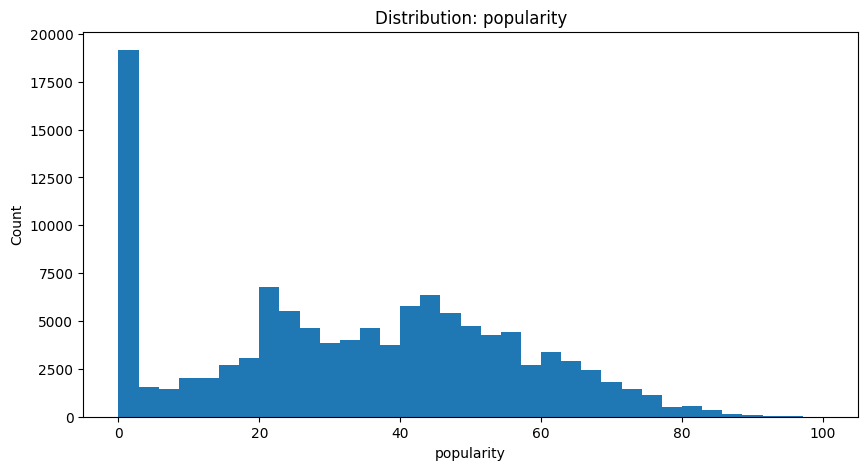

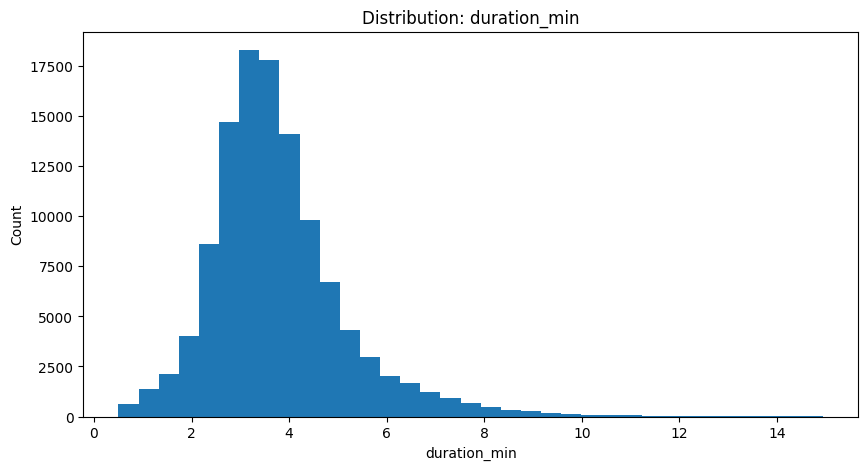

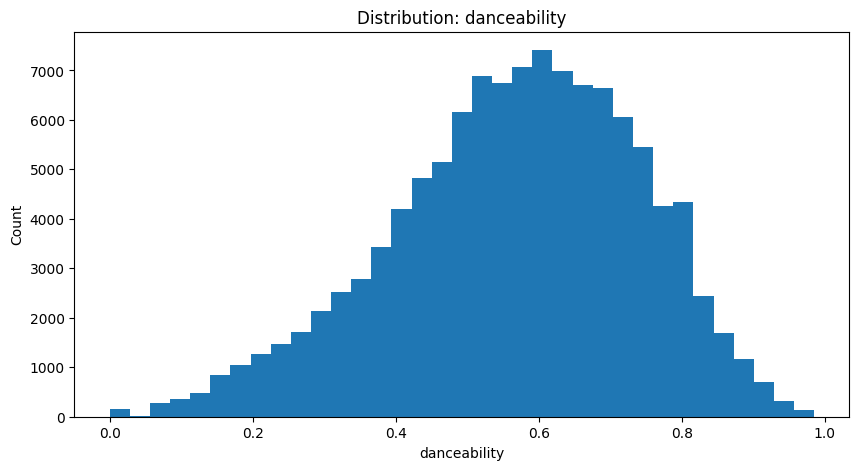

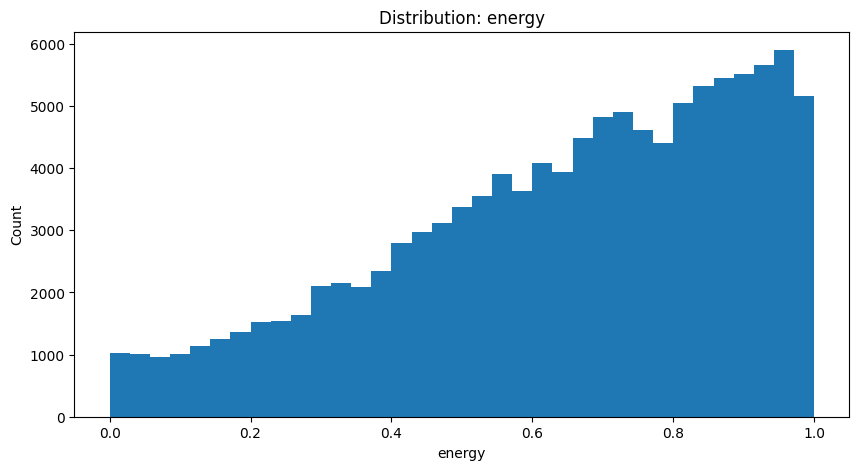

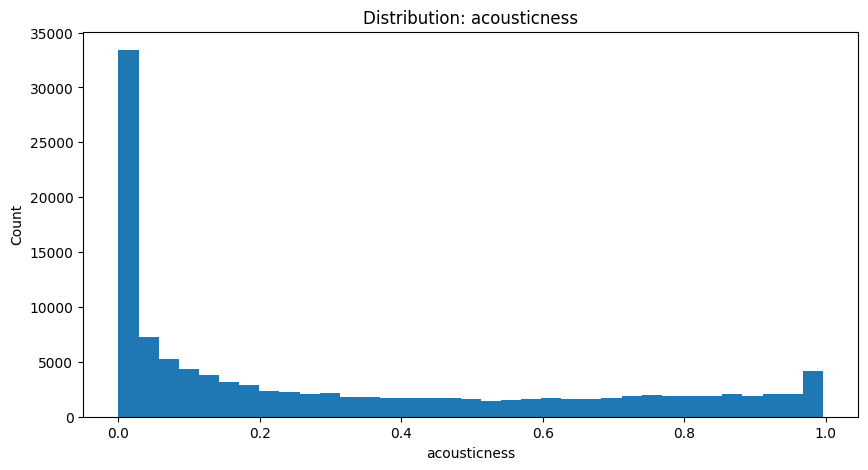

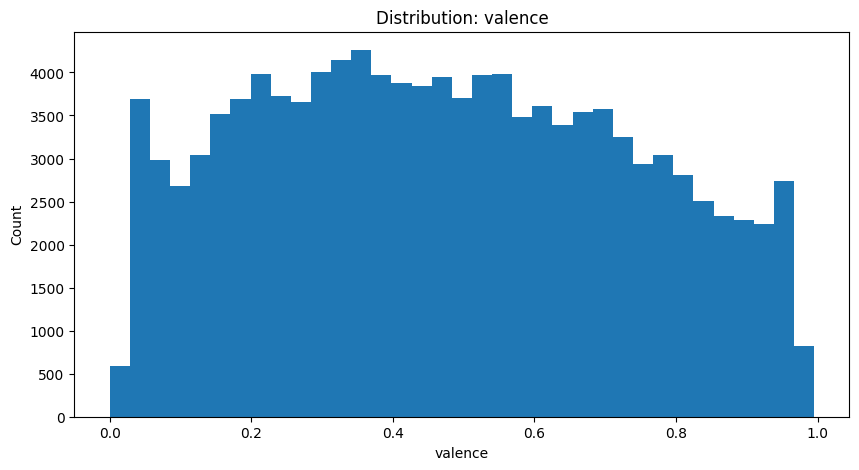

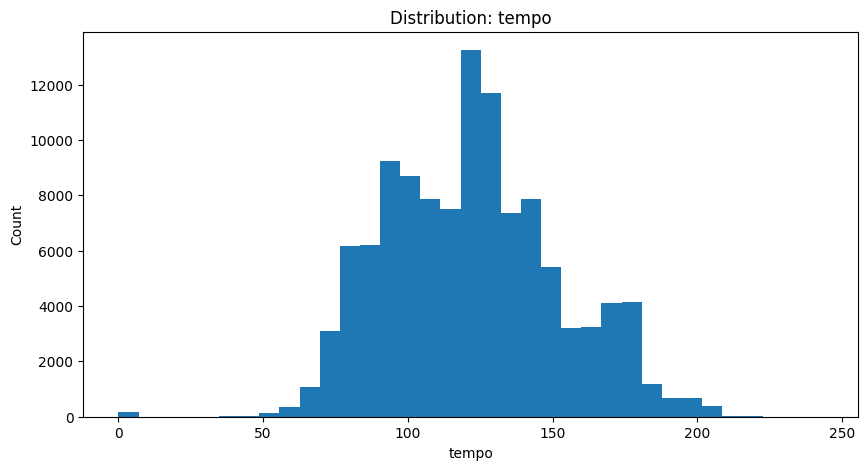

In [8]:
# Helper: histogram with safe column checks
def hist_col(col, bins=30, title=None):
    if col not in df.columns:
        print(f"Missing column: {col}")
        return
    s = df[col].dropna()
    plt.figure()
    plt.hist(s, bins=bins)
    plt.title(title or f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

for c in ["popularity", "duration_min", "danceability", "energy", "acousticness", "valence", "tempo"]:
    if c in df.columns:
        hist_col(c, bins=35)

**Interpretation**

The popularity distribution is highly right-skewed, with a large mass of tracks concentrated at very low popularity scores and a long tail extending toward highly popular tracks. This suggests that the dataset contains a substantial number of tracks that receive little to no engagement, while only a small fraction achieve widespread visibility. This imbalance is consistent with a “winner-take-most” dynamic common in content platforms, where attention is unevenly distributed across a large catalog.

The spike near zero popularity likely reflects newly released, niche, or minimally promoted tracks, highlighting that popularity should be interpreted as a relative platform metric rather than an intrinsic measure of musical quality.

### 4.1 Popularity tiers (quick snapshot)


,count
popularity_tier,
0-20,34105
21-40,33083
41-60,33072
61-80,12616
81-100,954


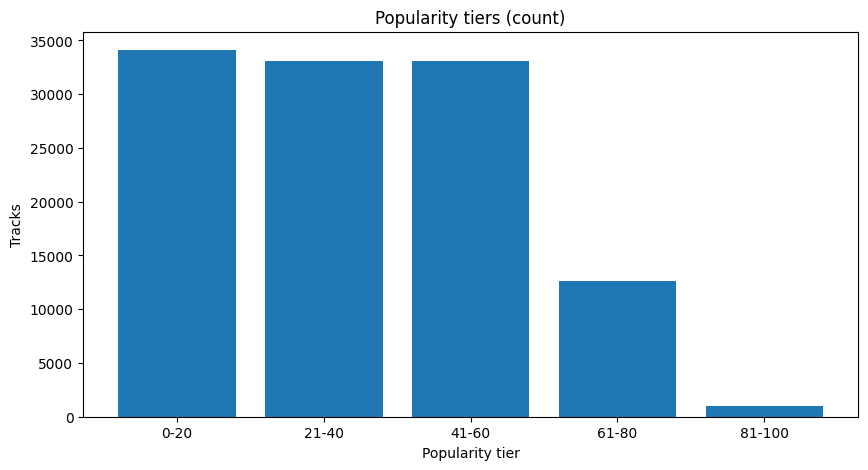

In [9]:
if "popularity_tier" in df.columns:
    tier_counts = df["popularity_tier"].value_counts().sort_index()
    display(tier_counts)

    plt.figure()
    plt.bar(tier_counts.index.astype(str), tier_counts.values)
    plt.title("Popularity tiers (count)")
    plt.xlabel("Popularity tier")
    plt.ylabel("Tracks")
    plt.show()

**Interpretation**

When grouped into discrete popularity tiers, the majority of tracks fall below a popularity score of 60, with a sharp drop-off in the 61–80 and 81–100 ranges. Tracks in the highest tier (81–100) represent a very small proportion of the dataset, reinforcing the idea that extreme popularity is rare.

This stratification supports treating popularity as a segmented outcome rather than a continuous one in downstream analysis, as tracks in different tiers may behave qualitatively differently.

## 5) Relationships & “story” insights
We’ll look for a few *interesting* patterns rather than generic plots:
- Is popularity more associated with **danceability** or **energy**?
- Do more popular tracks tend to be shorter (radio-friendly) in this dataset?
- How does **explicit** content relate to popularity distribution?
- Are there distinct “clusters” of audio features that correspond to different vibes?


In [10]:
# Correlations against popularity
if "popularity" in df.columns:
    audio_cols = [c for c in ["danceability","energy","loudness","speechiness","acousticness",
                             "instrumentalness","liveness","valence","tempo","duration_min",
                             "hype_proxy","chill_proxy"] if c in df.columns]
    corr = df[audio_cols + ["popularity"]].corr(numeric_only=True)["popularity"].sort_values(ascending=False)
    display(corr)

,popularity
popularity,1.000000
loudness,0.049335
danceability,0.034819
tempo,0.012992
hype_proxy,0.006652
energy,0.000328
duration_min,-0.000615
liveness,-0.005316
chill_proxy,-0.019901
acousticness,-0.024917


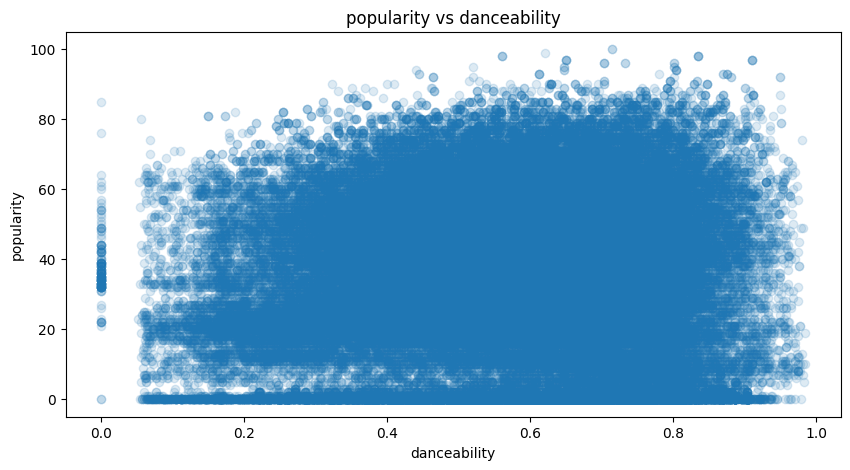

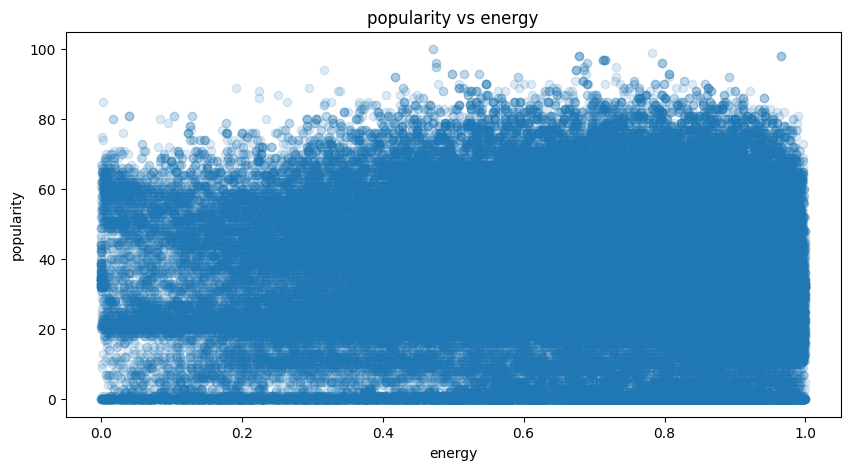

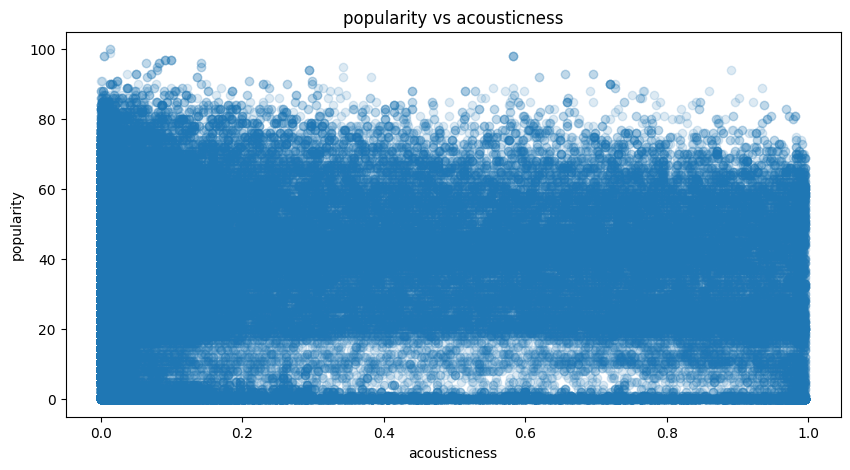

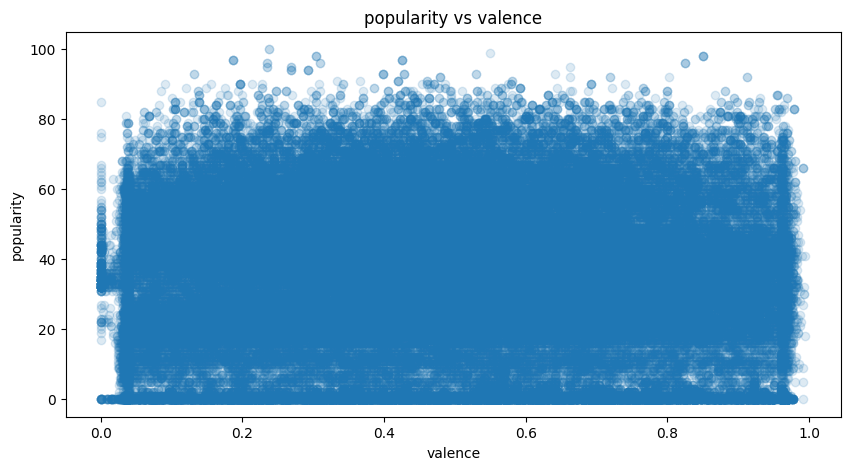

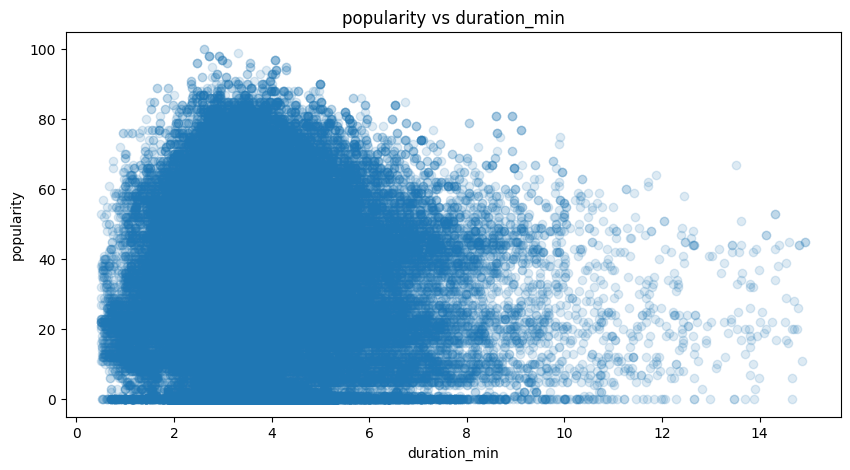

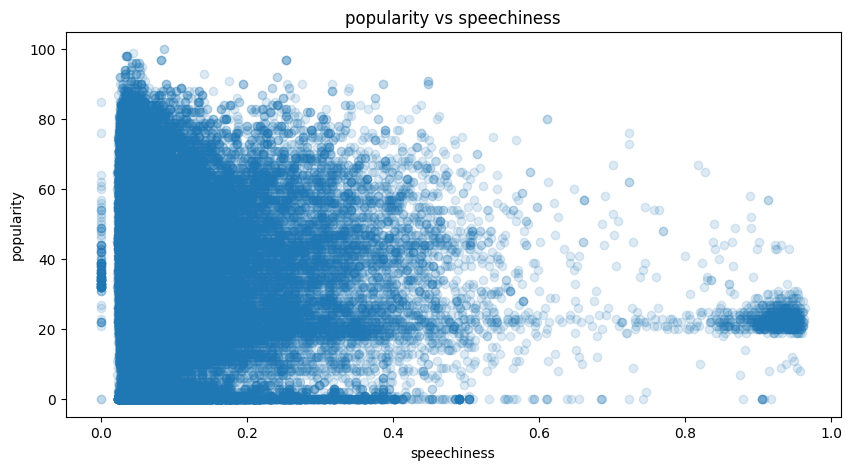

In [11]:
# Scatter: popularity vs key audio features
def scatter(x, y, alpha=0.15):
    if x not in df.columns or y not in df.columns:
        print("Missing:", x, y)
        return
    plt.figure()
    plt.scatter(df[x], df[y], alpha=alpha)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{y} vs {x}")
    plt.show()

if "popularity" in df.columns:
    for feat in ["danceability", "energy", "acousticness", "valence", "duration_min", "speechiness"]:
        if feat in df.columns:
            scatter(feat, "popularity")

### Interpretation: Popularity vs Track Duration

The relationship between track duration and popularity is weak but structured. Highly popular tracks tend to cluster within a relatively narrow duration range (approximately 2–5 minutes), while longer tracks show greater variance in popularity but rarely reach the highest popularity levels.

This suggests the presence of a soft “radio-friendly” duration window, where tracks outside this range may face diminishing engagement returns.


### 5.1 A simple “radio-friendliness” check
We’ll compare median duration across popularity tiers.


/tmp/ipython-input-1235913721.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med = df.groupby("popularity_tier")["duration_min"].median()


,duration_min
popularity_tier,
0-20,3.459050
21-40,3.595300
41-60,3.601783
61-80,3.520858
81-100,3.445025


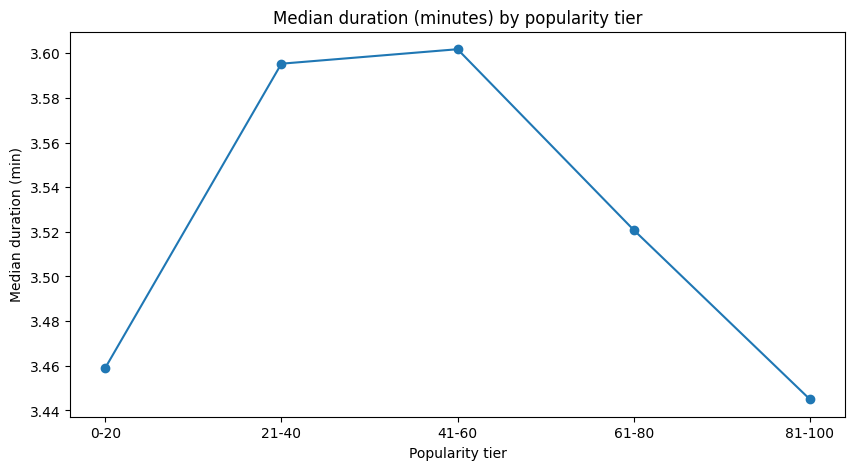

In [12]:
if set(["duration_min", "popularity_tier"]).issubset(df.columns):
    med = df.groupby("popularity_tier")["duration_min"].median()
    display(med)

    plt.figure()
    plt.plot(med.index.astype(str), med.values, marker="o")
    plt.title("Median duration (minutes) by popularity tier")
    plt.xlabel("Popularity tier")
    plt.ylabel("Median duration (min)")
    plt.show()

### Interpretation: Duration by Popularity Tier

Median track duration increases slightly from the lowest popularity tier to mid-range popularity, before declining again for the most popular tracks. This non-linear pattern suggests that while extremely short tracks may be less effective, the most popular songs converge toward a standardized duration.

Rather than a monotonic relationship, duration appears to be optimized within a narrow band among top-performing tracks.


### 5.2 Explicit content and popularity
This is descriptive only (no causality). We compare distributions and summary stats.


,count,mean,median
explicit,,,
0,104089,32.953482,34.0
1,9741,36.463299,37.0


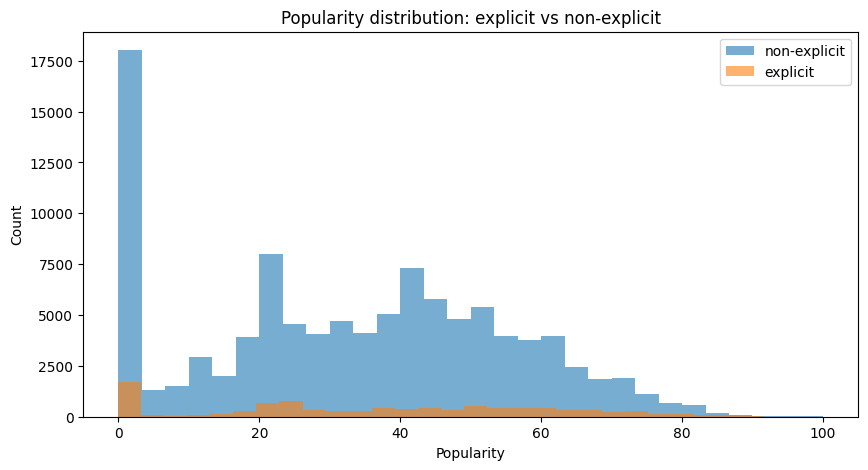

In [13]:
if set(["explicit", "popularity"]).issubset(df.columns):
    exp_stats = df.groupby("explicit")["popularity"].agg(["count", "mean", "median"])
    display(exp_stats)

    # Simple side-by-side hist
    plt.figure()
    plt.hist(df.loc[df["explicit"]==0, "popularity"].dropna(), bins=30, alpha=0.6, label="non-explicit")
    plt.hist(df.loc[df["explicit"]==1, "popularity"].dropna(), bins=30, alpha=0.6, label="explicit")
    plt.title("Popularity distribution: explicit vs non-explicit")
    plt.xlabel("Popularity")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

### Interpretation: Explicit Content and Popularity

Explicit tracks show slightly higher average and median popularity compared to non-explicit tracks, despite representing a smaller share of the dataset. This suggests that explicit content does not negatively impact popularity and may be associated with genres or audiences that perform well on the platform.

However, the substantial overlap between distributions indicates that explicitness alone is not a primary driver of popularity.

### 5.3 “Mood quadrant” segmentation
I'm using a fun interpretability trick here:
- x-axis: valence (sad ↔ happy)
- y-axis: energy (calm ↔ intense)

Then we compare popularity by quadrant.


,count,mean,median
mood_quadrant,,,
Low valence / Low energy,33417,35.046653,39.0
Low valence / High energy,23424,33.170936,32.0
High valence / High energy,33533,32.418245,33.0
High valence / Low energy,23456,31.977021,32.0


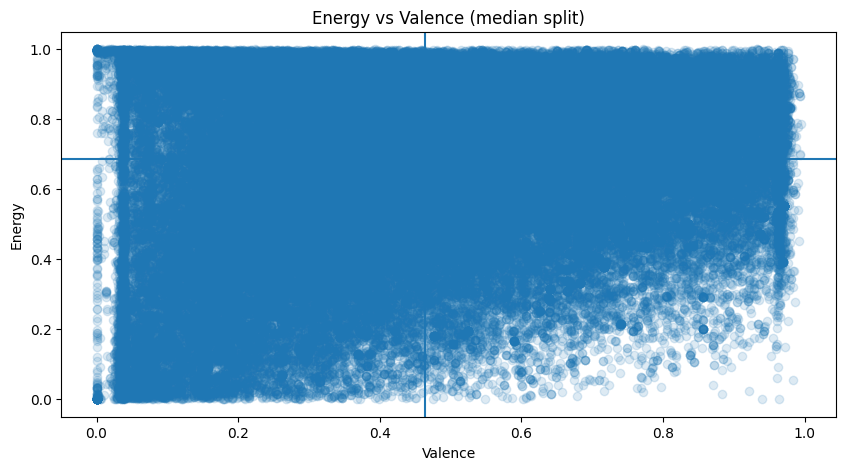

In [14]:
if set(["valence", "energy", "popularity"]).issubset(df.columns):
    v_med = df["valence"].median()
    e_med = df["energy"].median()

    def quadrant(row):
        if row["valence"] >= v_med and row["energy"] >= e_med:
            return "High valence / High energy"
        if row["valence"] < v_med and row["energy"] >= e_med:
            return "Low valence / High energy"
        if row["valence"] >= v_med and row["energy"] < e_med:
            return "High valence / Low energy"
        return "Low valence / Low energy"

    df["mood_quadrant"] = df[["valence","energy"]].apply(quadrant, axis=1)
    quad = df.groupby("mood_quadrant")["popularity"].agg(["count","mean","median"]).sort_values("mean", ascending=False)
    display(quad)

    # Scatter plot showing quadrants
    plt.figure()
    plt.scatter(df["valence"], df["energy"], alpha=0.15)
    plt.axvline(v_med)
    plt.axhline(e_med)
    plt.title("Energy vs Valence (median split)")
    plt.xlabel("Valence")
    plt.ylabel("Energy")
    plt.show()

### Interpretation: Mood Quadrants (Energy × Valence)

Segmenting tracks by median splits on energy and valence reveals meaningful differences in popularity. Tracks with low valence and low energy exhibit the highest median popularity, while high valence and low energy tracks perform worst on average.

This suggests that emotionally subdued or introspective tracks may resonate more strongly with listeners than purely upbeat content, challenging the assumption that high positivity alone drives engagement.


## 6) Outliers & data integrity checks
We’ll inspect:
- extreme tempo values
- very high instrumentalness and how it interacts with popularity


In [15]:
# Tempo sanity (many datasets contain tempo outliers due to estimation artifacts)
if "tempo" in df.columns:
    q = df["tempo"].quantile([0.01, 0.05, 0.5, 0.95, 0.99])
    display(q)
    # Flag suspicious tempos (>220 BPM or <40 BPM)
    suspicious = df[(df["tempo"] > 220) | (df["tempo"] < 40)]
    print("Suspicious tempo rows:", suspicious.shape[0])
    suspicious.head()

,tempo
0.01,66.29116
0.05,77.36490
0.50,122.01800
0.95,175.07300
0.99,194.00484


Suspicious tempo rows: 178


,count,mean,median
instrumentalness,,,
<0.7,98322,34.013873,36.0
>=0.7,15508,28.435130,25.0


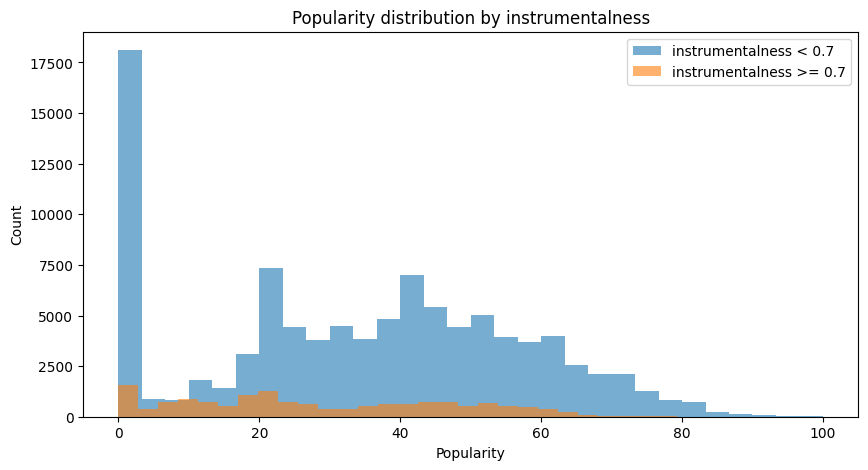

In [16]:
if set(["instrumentalness", "popularity"]).issubset(df.columns):
    # Compare popularity of highly instrumental tracks vs others
    high_inst = df["instrumentalness"] >= 0.7
    inst_stats = df.groupby(high_inst)["popularity"].agg(["count","mean","median"]).rename(index={False:"<0.7", True:">=0.7"})
    display(inst_stats)

    plt.figure()
    plt.hist(df.loc[~high_inst, "popularity"].dropna(), bins=30, alpha=0.6, label="instrumentalness < 0.7")
    plt.hist(df.loc[high_inst, "popularity"].dropna(), bins=30, alpha=0.6, label="instrumentalness >= 0.7")
    plt.title("Popularity distribution by instrumentalness")
    plt.xlabel("Popularity")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

### Interpretation: Instrumentalness and Popularity

Tracks with high instrumentalness have substantially lower mean and median popularity compared to tracks with more vocal content. This indicates that instrumental tracks tend to occupy more niche positions within the platform ecosystem.

The result aligns with listener preferences for vocal-driven tracks in mainstream playlists, while instrumental music may perform better in specialized or contextual settings.


## 7) Multivariate structure: PCA + Clustering (EDA-only)
This is not “modeling for prediction”—we use PCA + KMeans to see whether audio features naturally form groups (vibes).


Explained variance ratio (PC1, PC2): [0.319 0.159]


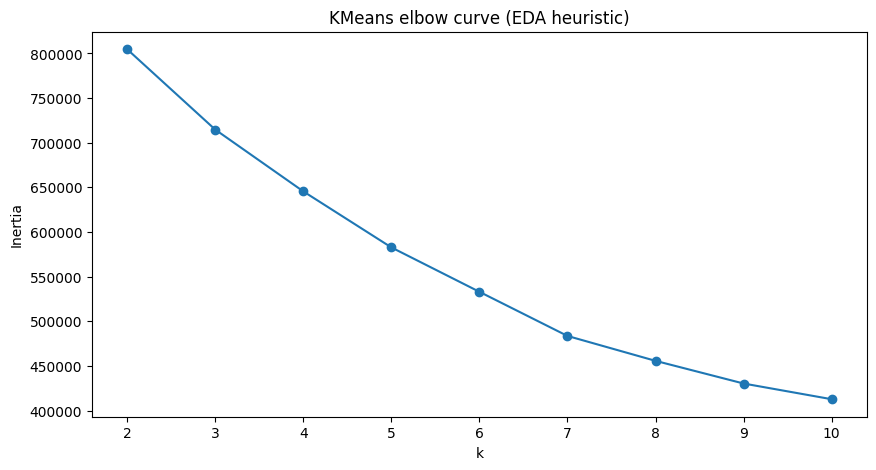

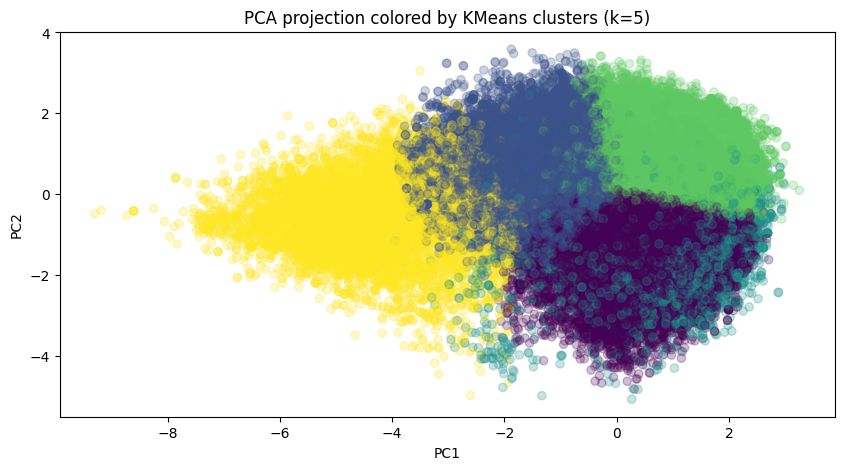

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,
0,0.481987,0.813731,-5.928717,0.079574,0.060087,0.230689,0.193049,0.319436,136.781449
1,0.537818,0.385621,-10.515198,0.054844,0.666262,0.050561,0.158662,0.397177,113.522783
2,0.533149,0.746819,-7.520341,0.192430,0.343688,0.065304,0.739001,0.502316,120.940096
3,0.696326,0.729944,-6.397888,0.090631,0.192807,0.054960,0.164904,0.689119,119.896617
4,0.364874,0.192940,-20.551863,0.052316,0.824300,0.788301,0.162265,0.190731,104.350710


In [17]:
# Choose numeric audio feature set (common subset)
feature_candidates = ["danceability","energy","loudness","speechiness","acousticness",
                      "instrumentalness","liveness","valence","tempo"]
features = [c for c in feature_candidates if c in df.columns]

if len(features) >= 6:
    X = df[features].dropna()
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    pca = PCA(n_components=2, random_state=0)
    Z = pca.fit_transform(Xs)

    print("Explained variance ratio (PC1, PC2):", np.round(pca.explained_variance_ratio_, 3))

    # Elbow heuristic for k=2..10
    inertias = []
    ks = range(2, 11)
    for k in ks:
        km = KMeans(n_clusters=k, random_state=0, n_init=10)
        km.fit(Xs)
        inertias.append(km.inertia_)

    plt.figure()
    plt.plot(list(ks), inertias, marker="o")
    plt.title("KMeans elbow curve (EDA heuristic)")
    plt.xlabel("k")
    plt.ylabel("Inertia")
    plt.show()

    # Pick a reasonable k for visualization
    k = 5
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = km.fit_predict(Xs)

    plt.figure()
    plt.scatter(Z[:,0], Z[:,1], c=labels, alpha=0.25)
    plt.title("PCA projection colored by KMeans clusters (k=5)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

    # Cluster profiling (means in original scale)
    cluster_profile = pd.DataFrame(X, columns=features).assign(cluster=labels).groupby("cluster").mean()
    display(cluster_profile)
else:
    print("Not enough audio features present to run PCA/Clustering. Found:", features)

### Interpretation: PCA and Clustering (Exploratory)

The PCA projection reveals structured but overlapping regions in the audio feature space. Clusters capture broad “vibe” groupings rather than sharply separable categories, reflecting the continuous nature of musical characteristics.

These clusters are useful for exploratory segmentation but should not be interpreted as definitive genre boundaries or predictors of popularity.


## Overall Takeaways

- Popularity is highly skewed, with a small fraction of tracks capturing disproportionate attention.
- Track duration exhibits a soft optimization window rather than a linear effect.
- Emotional tone (energy and valence) provides more insight than individual audio features.
- Instrumental tracks are structurally less likely to achieve high popularity.
- Popularity is best understood as an emergent outcome shaped by multiple interacting factors rather than any single attribute.


## What Can Be Done With This Data

This exploratory analysis highlights several directions for deeper analytical and applied work:

**Predictive Modeling:**  
The audio features and engineered proxies (e.g., duration, mood quadrants, instrumentalness) provide a foundation for building models that predict popularity tiers or relative performance. While popularity is influenced by external factors, feature-driven models could still be useful for ranking or comparative analysis.

**Segmentation & Recommendation:**  
The PCA and clustering results suggest that tracks form broad “vibe” groupings rather than discrete genres. These segments could support recommendation systems, playlist generation, or similarity-based discovery without relying on explicit genre labels.

**Content Strategy & Optimization:**  
Insights around track duration, instrumentalness, and mood characteristics could inform decisions about track composition or positioning, particularly for creators or curators aiming to reach broader audiences.

**Causal & Longitudinal Analysis:**  
Future work could incorporate time-based data (release dates, popularity trajectories) to study how tracks gain or lose popularity over time and whether certain audio features are associated with faster growth or longer-lived engagement.

**Ethical & Platform Considerations:**  
Because popularity reflects platform dynamics as much as listener preference, care should be taken when using these metrics for decision-making. Any downstream use should acknowledge bias toward already-promoted or algorithmically favored content.

Overall, this dataset supports a wide range of descriptive, predictive, and exploratory applications, with the strongest value emerging when audio features are combined with contextual and temporal information.
